In [4]:
import torch as t
from IPython.display import display
import circuitsvis as cv
import numpy as np

from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)

from arithmetic import detokenize, tokenize, chars, generate_completion_with_cache

from huggingface_hub import hf_hub_download


device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")


cfg = HookedTransformerConfig(
    d_model=768,
    d_head=64,
    n_heads=12,
    n_layers=2,
    n_ctx=2048,
    d_vocab=len(chars),
    attention_dir="causal",
    attn_only=True,  # defaults to False
    seed=398,
    use_attn_result=True,
    normalization_type=None,  # defaults to "LN", i.e. layernorm with weights & biases
    positional_embedding_type="shortformer",
)

weights_path = "models/arithmetic_model_2layers/model_weights.pt"

model = HookedTransformer(cfg)
pretrained_weights = t.load(weights_path, map_location=device, weights_only=True)
model.load_state_dict(pretrained_weights)
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (ln1): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_attn_input): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

### Experiment 1 - View attention pattern for sample problem
---

Key here is to find if there are any underlaying patterns that can be immediately spotted

In [55]:
text = ".224.+.441.=665"
def to_str_tokens(text):
    return [detokenize([i]) for i in tokenize(text)]
str_tokens = to_str_tokens(text)


In [56]:
import torch
inp = torch.tensor([tokenize(text)], dtype=torch.long).to(device)
logits, cache = model.run_with_cache(inp, remove_batch_dim=True)

In [57]:
attention_pattern = cache["pattern", 0]
attention_pattern.shape

torch.Size([12, 15, 15])

In [62]:
for layer in range(model.cfg.n_layers):
    attention_pattern = cache["pattern", layer]
    display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern))

### Experiment 2 - Understand average attention head activation over sample range of problems
---

Seems that there are multiple heads that are attending to a specific digit position in the previous example. Need to find if these attention heads are attending to a specific character, or if heads are dedicated to a single position. Will average over a sample range of problems to test.

In [49]:
from arithmetic import generate_addition_dataset

def collect_average_attention_patterns(model, n_samples=100):
    sample_dataset = generate_addition_dataset(dataset_size=100, min_digits=3, max_digits=3)

    attention_patterns_l1 = []
    attention_patterns_l2 = []

    for i in range(n_samples):
        inp = torch.tensor([tokenize(sample_dataset[i])], dtype=torch.long).to(device)
        _, cache = model.run_with_cache(inp, remove_batch_dim=True)
        attention_patterns_l1.append(cache["pattern", 0])
        attention_patterns_l2.append(cache["pattern", 1])

    # Find maximum sequence length
    max_length = max(pattern.shape[1] for pattern in attention_patterns_l1)
    
    # Pad patterns to same length in both dimensions
    attention_patterns_l1 = [torch.nn.functional.pad(pattern, (0, max_length - pattern.shape[2], 0, max_length - pattern.shape[1])) for pattern in attention_patterns_l1]
    attention_patterns_l2 = [torch.nn.functional.pad(pattern, (0, max_length - pattern.shape[2], 0, max_length - pattern.shape[1])) for pattern in attention_patterns_l2]

    # Stack and average patterns
    attention_patterns_l1_avg = torch.stack(attention_patterns_l1).mean(dim=0)
    attention_patterns_l2_avg = torch.stack(attention_patterns_l2).mean(dim=0)

    return attention_patterns_l1_avg, attention_patterns_l2_avg

In [50]:
average_patterns = collect_average_attention_patterns(model, n_samples=100)

In [ ]:
for layer in range(model.cfg.n_layers):
    attention_pattern = average_patterns[layer]
    display(cv.attention.attention_heads(tokens=str_tokens, attention=attention_pattern))

#### Analysis

Seems that the heads are indeed attending to a specific digit position.

### Experiment 3 - Understand the QK and OV matrices
---
If a singular attention head is dedicated on a specific digit in this toy example, we may be able to reconstruct how computation is performed by calculating the OV and QK matrices.

In [71]:
## Adopted from 

from arithmetic import chars
import matplotlib.pyplot as plt
from fancy_einsum import einsum


def calculate_qk_attn_heatmap(model, keypos=-1, querypos=-1):
    attn = model.blocks[0].attn
    all_token_embeddings = model.embed(range(len(chars)))
    positional_embeddings = model.pos_embed(all_token_embeddings)

    token_embeddings_at_keypos = (
        all_token_embeddings + positional_embeddings[:, keypos, :]
        if keypos > -1 else all_token_embeddings
    )
    token_embeddings_at_querypos = (
        all_token_embeddings + positional_embeddings[:, querypos, :]
        if querypos > -1 else all_token_embeddings
    )

    embeddings_key = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_keypos, attn.W_K,
    )
    embeddings_query = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_querypos, attn.W_Q,
    )

    plt.rcParams["figure.figsize"] = [20, 10]
    qk_circuit_attn_heatmap = einsum(
        "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k",
        embeddings_query, embeddings_key,
    ).detach().cpu().numpy()

    return qk_circuit_attn_heatmap

def plot_qk_heatmap(model, keypos=-1, querypos=-1):
    qk_attn_heatmap = calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos)

    fig, ax = plt.subplots(figsize=(8, 8))
    graph = ax.imshow(qk_attn_heatmap, cmap="hot", interpolation="nearest")
    plt.colorbar(graph)
    
    # Set x and y ticks to show the tokens from the global variable `chars`
    ax.set_xticks(np.arange(len(chars)))
    ax.set_xticklabels(list(chars))
    ax.set_yticks(np.arange(len(chars)))
    ax.set_yticklabels(list(chars))
    plt.xticks(rotation=90)
    
    plt.tight_layout()

def plot_avg_qk_heatmap(model, keypositions, querypos=-1):
    heatmaps = []
    for keypos in keypositions:
        heatmaps.append(calculate_qk_attn_heatmap(model, keypos=keypos, querypos=querypos))

    qk_circuit_attn_heatmap = np.mean(heatmaps, axis=0)

    fig, ax = plt.subplots(figsize=(8, 8))
    graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
    plt.colorbar(graph)
    
    # Set x and y ticks to show the tokens from the global variable `chars`
    ax.set_xticks(np.arange(len(chars)))
    ax.set_xticklabels(list(chars))
    ax.set_yticks(np.arange(len(chars)))
    ax.set_yticklabels(list(chars))
    plt.xticks(rotation=90)
    
    plt.tight_layout()

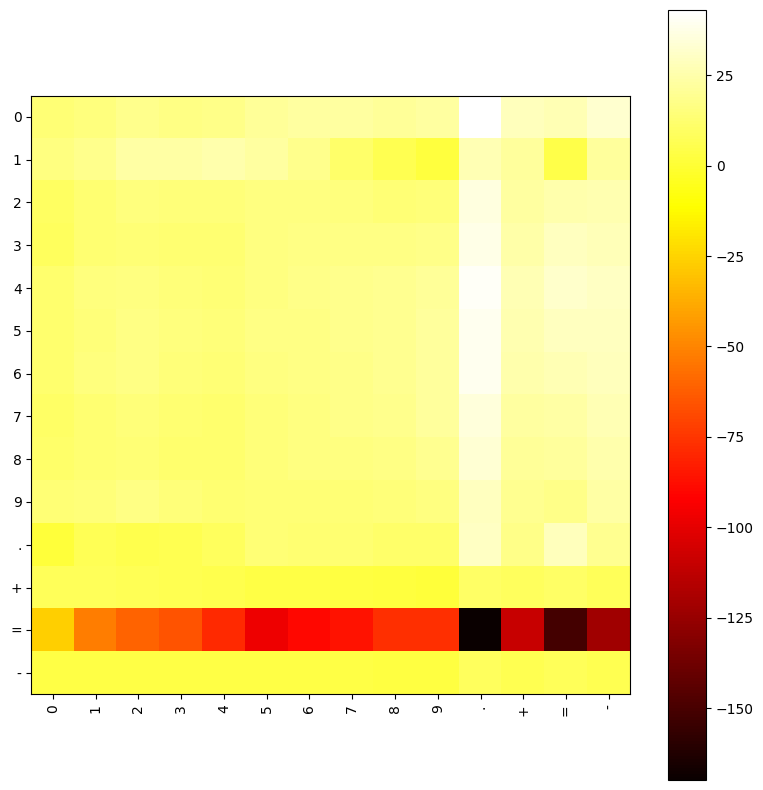

In [72]:
plot_avg_qk_heatmap(model, keypositions=[0, 1], querypos=-1)

In [73]:
def plot_ov_heatmap(model, pos=-1):
    attn = model.blocks[0].attn
    all_token_embeddings = model.embed(range(len(chars)))

    token_embeddings_at_pos = (
        all_token_embeddings + model.pos_embed(all_token_embeddings)[:, pos, :]
        if pos > -1 else all_token_embeddings
    )

    embeddings_value = einsum(
        "d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head",
        token_embeddings_at_pos, attn.W_V
    )

    embeddings_out = einsum(
        "n_heads d_vocab d_model1, n_heads d_model1 d_model2 -> n_heads d_vocab d_model2",
        embeddings_value, attn.W_O
    )

    ov_circuit_attn_heatmap = model.unembed(embeddings_out).detach().cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    graph = ax.imshow(ov_circuit_attn_heatmap[0], cmap="hot", interpolation="nearest")
    plt.colorbar(graph)
    
    # Set x and y ticks to display tokens from `chars`
    ax.set_xticks(np.arange(len(chars)))
    ax.set_xticklabels(list(chars))
    ax.set_yticks(np.arange(len(chars)))
    ax.set_yticklabels(list(chars))
    plt.xticks(rotation=90)
    
    plt.tight_layout()

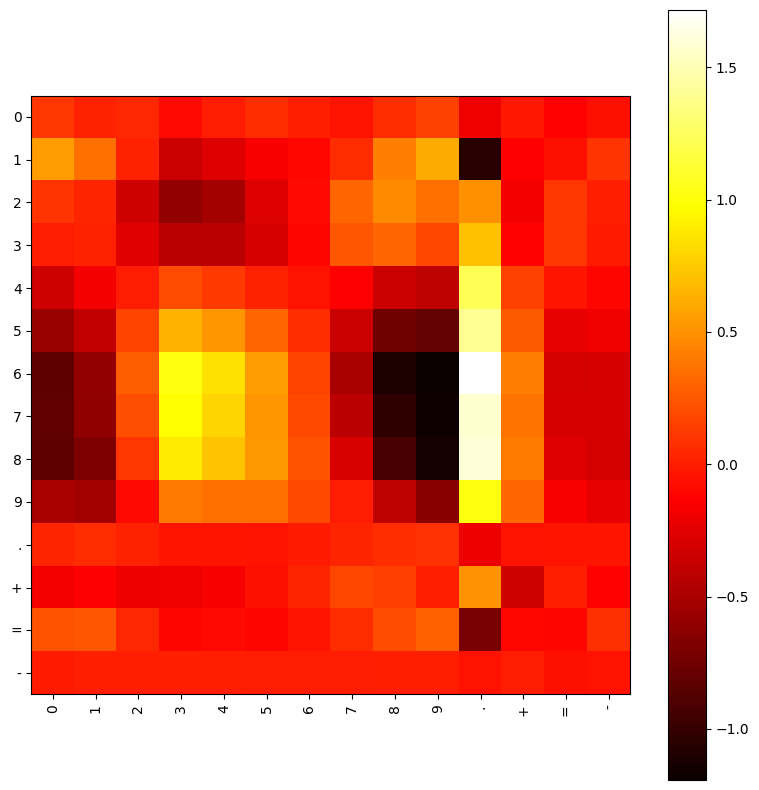

In [74]:
plot_ov_heatmap(model, pos=-1)